In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from google.colab import drive
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import simps

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path_prefix = '/content/drive/Shared drives/CS 230 Project (EEG)/'
data = np.load(path_prefix + 's44_data.npy')
#labels = np.load(path_prefix + 's44_labels.npy')

# data = np.load(path_prefix + 'combined_subjects_data.npy')
# cluster = 'combined_subjects_f_cluster_diff_data.npy'
# data = np.load(path_prefix + cluster)
labels = np.load(path_prefix + 'combined_subjects_labels.npy')

In [5]:
print(np.shape(data))

(2309, 30, 500)


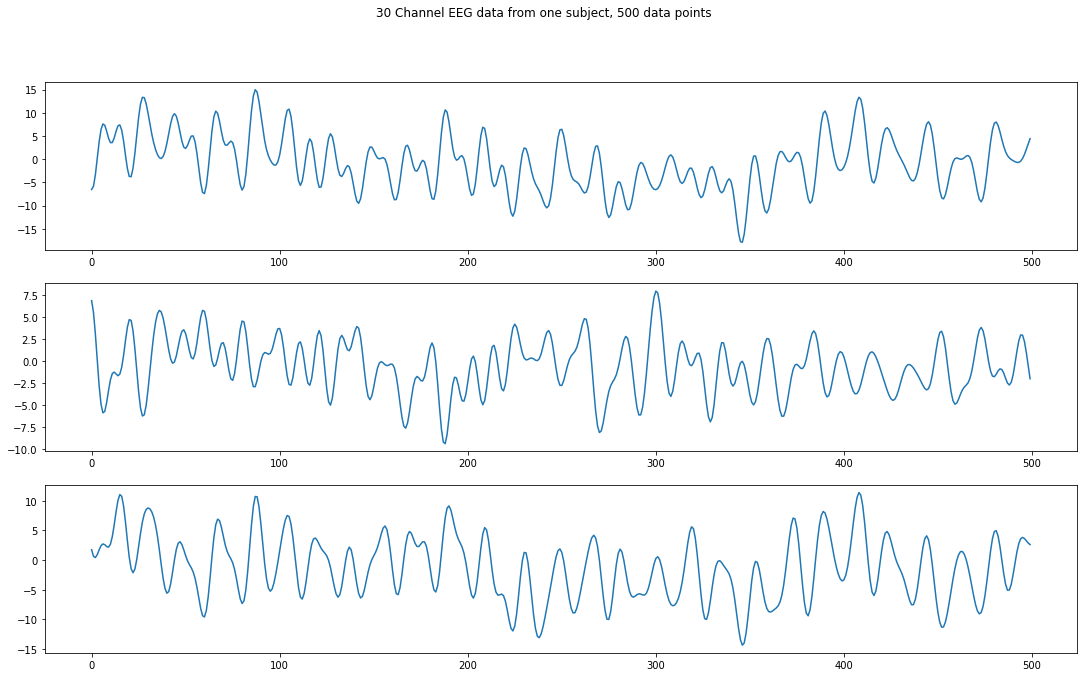

In [0]:
fig, axs = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)
fig.suptitle('30 Channel EEG data from one subject, 500 data points')
for i in range(data.shape[1]):
    axs[i].plot(data[0, i, :])

In [0]:
print(np.shape(data))

(26065, 3, 500)


(0.0, 30.0)

<Figure size 432x288 with 0 Axes>

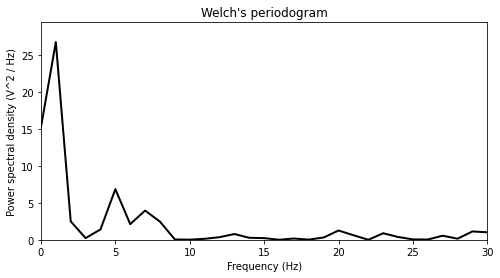

In [6]:
#Set window length and sampling frequency
sf = 500
win = 1 * sf
freqs, psd = signal.welch(data[0][0], sf, nperseg=win)

fig = plt.figure()
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 30])

In [0]:
# Define delta lower and upper limits
low, high = 1, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Frequency resolution
freq_res = freqs[1] - freqs[0]
print(freq_res)

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

1.0
Absolute delta power: 4.381 uV^2
Relative delta power: 0.302


In [0]:
def bandpower(data, sf, bands, method='multitaper', window_sec=None, relative=False, band_power_mode=True):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    bps = []
    # print('bands', bands)
    for band in bands:
      band = np.asarray(band)
      # print('band', band)
      low, high = band

      # Compute the modified periodogram (Welch)
      if method == 'welch':
          if window_sec is not None:
              nperseg = window_sec * sf
          else:
              nperseg = (2 / low) * sf

          freqs, psd = welch(data, sf, nperseg=nperseg)

      elif method == 'multitaper':
          psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)

      # Frequency resolution
      freq_res = freqs[1] - freqs[0]

      # Find index of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)
      bp = simps(psd[idx_band], dx=freq_res)
      bps.append(bp)
    
    return bps/simps(psd, dx=freq_res)

    '''if band_power_mode:
      # Integral approximation of the spectrum using parabola (Simpson's rule)
      bp = simps(psd[idx_band], dx=freq_res)

      if relative:
          bp /= simps(psd, dx=freq_res)
      return bp
    else:
      return psd[idx_band]'''

In [7]:
!pip install mne

     |████████████████████████████████| 6.6MB 106kB/s 


In [0]:
# Multitaper delta power
row = 1
col = 1
bp = bandpower(data[row][col], sf, [0.5, 4], 'multitaper')
bp_rel = bandpower(data[row][col], sf, [0.5, 4], 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel)

# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(data[row][col], sf, [0.5, 4], 'multitaper') / bandpower(data[row][col], sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data[row][col], sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(data[row][col], sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

TypeError: ignored

In [11]:
print(np.shape(data))
data_full = data
for i in range(10):
  print(i)

(2309, 30, 500)
0
1
2
3
4
5
6
7
8
9


In [12]:
clusters = {}
clusters['a'] = [4, 0, 1, 3]
clusters['b'] = [8, 2, 3, 7]
clusters['c'] = [18, 12, 13, 17]
clusters['d'] = [24, 27, 28, 29]
clusters['e'] = [21, 15, 16, 20]
clusters['f'] = [10, 5, 6, 11]

print(data_full.shape)
test = data_full[:,clusters['a'],:]
print(test.shape)

(2309, 30, 500)
(2309, 4, 500)


In [13]:
# COPIED, FOR S44 CLUSTERS
for key in clusters.keys():
  cluster = clusters[key]
  data = data_full[:, cluster[1:], :] - data_full[:, [cluster[0]], :]
  freq_bands = [[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
  print(data.shape)
  psd_data = np.zeros((np.shape(data)[0], np.shape(data)[1], len(freq_bands)))

  sf = 500

  count = 0
  rows = np.shape(data)[0]
  cols = np.shape(data)[1]
  total = rows*cols
  total = total - (total % 10)
  print(total)
  for i in range(rows):
    for j in range(cols):
      bp_rel = bandpower(data[i][j], sf, freq_bands, 'multitaper', relative=True)
      psd_data[i][j] = np.array(bp_rel)
      count += 1
      if count % (total/10) == 0:
        print("Finished " + str(count/total*100) + "% of calculations")
  print(path_prefix + 's44_psd_'+key+'_diff.npy', psd_data)
  np.save(path_prefix + 's44_psd_'+key+'_diff.npy', psd_data)

(2309, 3, 500)
6920


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 10.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 20.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 30.0% of calculations
Finished 40.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 50.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 60.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 70.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 80.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 90.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 100.0% of calculations
/content/drive/Shared drives/CS 230 Project (EEG)/s44_psd_a_diff.npy [[[0.29341045 0.19890609 0.1015008  0.18976291 0.11518854]
  [0.28663043 0.1908894  0.10237868 0.18859023 0.14854952]
  [0.33543617 0.26964765 0.10017937 0.12696286 0.0460377 ]]

 [[0.03757712 0.04228105 0.01698513 0.4020344  0.49271503]
  [0.10912886 0.04834819 0.01974834 0.35088145 0.4359633 ]
  [0.18420492 0.2307993  0.09918012 0.28004849 0.14632035]]

 [[0.33158646 0.11771349 0.06133975 0.20656453 0.17472681]
  [0.20047414 0.15920052 0.11871498 0.30621744 0.14538836]
  [0.30426522 0.17710778 0.11888251 0.20909219 0.09115259]]

 ...

 [[0.36143025 0.22526514 0.05003494 0.16863722 0.04930816]
  [0.3271376  0.27027346 0.0505911  0.13559957 0.08711819]
  [0.54071915 0.12820237 0.0319335  0.05014114 0.04777467]]

 [[0.25898285 0.14106729 0.1125836  0.30013116 0.10080682]
  [0.16303979 0.1384763  0.07691699 0.42569529 0.13581292]
  [0.21443413 0.18389949 0.08727593 0.21088789 0.23151076]]

<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 10.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 20.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 30.0% of calculations
Finished 40.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 50.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 60.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 70.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 80.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 90.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 100.0% of calculations
/content/drive/Shared drives/CS 230 Project (EEG)/s44_psd_b_diff.npy [[[0.3097215  0.22263981 0.10426381 0.1893775  0.09784784]
  [0.3918233  0.1993932  0.05503323 0.12791182 0.05302631]
  [0.41715332 0.24285386 0.11969767 0.09795225 0.0230284 ]]

 [[0.14214438 0.14180512 0.03236008 0.34696531 0.29842143]
  [0.36650181 0.15455168 0.07365817 0.18387652 0.09932713]
  [0.28572624 0.24136756 0.06046052 0.22295567 0.10797897]]

 [[0.29835968 0.20530776 0.10311028 0.18575498 0.09643419]
  [0.43152432 0.18465503 0.04623666 0.15643886 0.02997346]
  [0.33340761 0.29587098 0.12781786 0.09611338 0.03944013]]

 ...

 [[0.29877077 0.21538458 0.07460765 0.217351   0.08096206]
  [0.27873699 0.12893151 0.12278294 0.22397481 0.15023483]
  [0.23324429 0.22745719 0.05465629 0.23942655 0.16918571]]

 [[0.26610444 0.21477902 0.06205901 0.2691854  0.09525119]
  [0.2179185  0.21208561 0.12851312 0.26053015 0.13437662]
  [0.16886432 0.15873871 0.08253564 0.36456716 0.16985315]]

<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 10.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 20.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 30.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 40.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 50.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 60.0% of calculations
Finished 70.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 80.0% of calculations
Finished 90.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 100.0% of calculations
/content/drive/Shared drives/CS 230 Project (EEG)/s44_psd_c_diff.npy [[[0.28703326 0.3593339  0.12401791 0.14280632 0.0279343 ]
  [0.34413651 0.28411256 0.13902911 0.08831228 0.02921078]
  [0.27719281 0.34398529 0.15233899 0.15783617 0.03599494]]

 [[0.29885222 0.23621627 0.11022642 0.18313367 0.11511747]
  [0.21685161 0.12084838 0.09636023 0.36792417 0.10729932]
  [0.18741489 0.20796916 0.11308934 0.30282313 0.1484701 ]]

 [[0.52146454 0.14533384 0.06782002 0.06614438 0.04060155]
  [0.32496202 0.30921151 0.11393766 0.10456627 0.05175527]
  [0.26273868 0.214863   0.16207    0.19461502 0.09473072]]

 ...

 [[0.29141875 0.28437184 0.11300443 0.14338755 0.09581347]
  [0.32766949 0.25198317 0.1299924  0.15107049 0.04647963]
  [0.24415997 0.29839002 0.12105314 0.10814305 0.16718069]]

 [[0.22622312 0.25228637 0.14540898 0.19739448 0.10339717]
  [0.35119387 0.1687369  0.09391957 0.18950378 0.08072921]
  [0.16539112 0.26720673 0.16187132 0.21709595 0.13297188]]

<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 10.0% of calculations
Finished 20.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 30.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 40.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 50.0% of calculations
Finished 60.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 70.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 80.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 90.0% of calculations
Finished 100.0% of calculations
/content/drive/Shared drives/CS 230 Project (EEG)/s44_psd_d_diff.npy [[[0.38994746 0.24704312 0.12085577 0.09739691 0.0272187 ]
  [0.2535067  0.29536357 0.15453256 0.14419706 0.05312477]
  [0.30830289 0.25279271 0.13981465 0.12676983 0.05255949]]

 [[0.13426781 0.22135336 0.28090039 0.27418952 0.04986303]
  [0.29963623 0.18854779 0.1506577  0.22187469 0.04842604]
  [0.30832138 0.19036186 0.12642845 0.24473663 0.03800263]]

 [[0.40890051 0.20026145 0.0984333  0.12380674 0.02627586]
  [0.32804686 0.20772179 0.10558556 0.19225181 0.0533881 ]
  [0.36833838 0.20955396 0.07630221 0.1753182  0.03635848]]

 ...

 [[0.29767269 0.25966613 0.11395855 0.19589585 0.04390363]
  [0.35619742 0.27103631 0.08821375 0.14684004 0.03118047]
  [0.40474767 0.24407335 0.06344275 0.12878477 0.0331737 ]]

 [[0.2144912  0.25526685 0.21174298 0.18553501 0.07262833]
  [0.20999508 0.38163632 0.14556541 0.15863501 0.06940599]
  [0.23490941 0.3472768  0.1

<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 10.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 20.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 30.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 40.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 50.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 60.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 70.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 80.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 90.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 100.0% of calculations
/content/drive/Shared drives/CS 230 Project (EEG)/s44_psd_e_diff.npy [[[0.18484674 0.26599984 0.17460219 0.21109789 0.11450046]
  [0.27135548 0.23426331 0.12156406 0.17338504 0.11207473]
  [0.11519764 0.23440225 0.20052344 0.31309999 0.10930243]]

 [[0.20740566 0.15667634 0.07461373 0.29403209 0.19747602]
  [0.19205685 0.09250088 0.04137672 0.33893903 0.27655575]
  [0.30444175 0.19208832 0.08994437 0.2067252  0.1005806 ]]

 [[0.27372502 0.26882862 0.13768758 0.15890348 0.08942536]
  [0.44338062 0.1414756  0.07835579 0.09824558 0.09613483]
  [0.25998235 0.22506379 0.16601506 0.16264838 0.10544211]]

 ...

 [[0.42306336 0.18847585 0.04009804 0.1529224  0.06149703]
  [0.13356851 0.21342786 0.10236332 0.27199881 0.24740359]
  [0.3273391  0.25200758 0.10909401 0.1516612  0.05061669]]

 [[0.12324451 0.21967336 0.1517121  0.33127468 0.14372066]
  [0.08613755 0.19001171 0.13536024 0.41260681 0.1496166 ]
  [0.09130255 0.24749733 0.24693181 0.30318463 0.09373353]]

<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 10.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 20.0% of calculations
Finished 30.0% of calculations
Finished 40.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 50.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 60.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 70.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipyth

Finished 80.0% of calculations


<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-8-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)


Finished 90.0% of calculations
Finished 100.0% of calculations
/content/drive/Shared drives/CS 230 Project (EEG)/s44_psd_f_diff.npy [[[0.1756898  0.11468793 0.12847581 0.27621317 0.24611639]
  [0.29158951 0.28470667 0.14052063 0.11995531 0.08065504]
  [0.18389169 0.38408464 0.23425285 0.10381654 0.05676253]]

 [[0.10623618 0.04247712 0.02734826 0.38870325 0.40199545]
  [0.1783072  0.11269755 0.03284811 0.33753917 0.27372875]
  [0.26341757 0.18493284 0.04789482 0.21954037 0.19367322]]

 [[0.09008254 0.14418212 0.09978176 0.36326881 0.28193479]
  [0.17919362 0.14619973 0.11967183 0.29847594 0.19948102]
  [0.26884145 0.27084697 0.11164859 0.15198372 0.08453225]]

 ...

 [[0.25305634 0.1644974  0.05993336 0.32495009 0.12707777]
  [0.24578818 0.22819668 0.0636141  0.23360786 0.16430165]
  [0.31368219 0.30175871 0.06731564 0.13015686 0.08437876]]

 [[0.10177114 0.14929078 0.16993545 0.3375333  0.20967512]
  [0.05724088 0.07642443 0.09673856 0.47851951 0.2744775 ]
  [0.09824151 0.14114253 0.1

In [0]:
# ORIGINAL

freq_bands = [[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
print(len(freq_bands))
psd_data = np.zeros((np.shape(data)[0], np.shape(data)[1], len(freq_bands)))

sf = 500

count = 0
rows = np.shape(data)[0]
cols = np.shape(data)[1]
total = rows*cols
total = total - (total % 10)
print(total)
for i in range(rows):
  for j in range(cols):
    bp_rel = bandpower(data[i][j], sf, freq_bands, 'multitaper', relative=True)
    psd_data[i][j] = np.array(bp_rel)
    count += 1
    if count % (total/10) == 0:
      print("Finished " + str(count/total*100) + "% of calculations")
np.save(path_prefix + 's44_psd_a_diff.npy', psd_data)


5
78190


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 10.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 20.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 30.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 40.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 50.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 60.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 70.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 80.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 90.0% of calculations


<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)
<ipython-input-27-08db6d22f8a6>:50: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  normalization='full', verbose=0)

Finished 100.0% of calculations


In [0]:
print(psd_data)

In [0]:
freq_bands = [[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
# freq_bands = [[0.5, 30]]
print(len(freq_bands))
psd_data = np.zeros((np.shape(data)[0], np.shape(data)[1], len(freq_bands)))

sf = 500

count = 0
rows = np.shape(data)[0]
cols = np.shape(data)[1]
total = rows*cols*len(freq_bands)
total = total - (total % 10)
print(total)
for i in range(rows):
  for j in range(cols):
    for k in range(len(freq_bands)):
      bp_rel = bandpower(data[i][j], sf, [freq_bands[k]], 'welch', relative=True, band_power_mode=True)
      #print(bp_rel.shape)
      psd_data[i][j] = bp_rel
      count += 1
      if count % (total/10) == 0:
        print("Finished " + str(count/total*100) + "% of calculations")

5
390970
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
band

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


Streaming output truncated to the last 5000 lines.
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands [[30, 100]]
band [ 30 100]
bands [[0.5, 4]]
band [0.5 4. ]
bands [[4, 8]]
band [4 8]
bands [[8, 12]]
band [ 8 12]
bands [[12, 30]]
band [12 30]
bands 

KeyboardInterrupt: ignored

In [0]:
np.save(path_prefix + 'combined_subjects_psd_e_diff.npy', psd_data)
# np.save(path_prefix + 'combined_subjects_psd_4.npy', psd_data)

In [0]:
print(bandpower(data[0][0], sf, [8,12], 'welch', relative=True))

0.15573710116603498
